In [153]:
import numpy as np
import torch
from torch.fft import fftshift, ifftn
from matplotlib import pyplot as plt

In [154]:
N = 64
fx1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), N)
fy1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), N)
[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D, indexing='xy')
k2D = torch.sqrt(fx2D**2 + fy2D**2) * N
theta2D = torch.arctan2(fy2D, fx2D)

In [155]:
def wavefront(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta - phi1) + C2 * torch.cos(2 * theta - phi2)

def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    psf = fftshift(ifftn(tf, dim=[-2,-1]), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1))
    return psf

0.0003125 -6.25e-05


<Figure size 420x420 with 0 Axes>

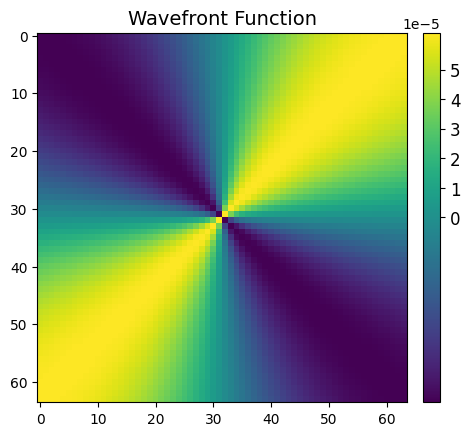

In [156]:
R = 0.005 # Radius to center.
l = 0.003 # Distance to center.
v0 = 1500.0 # Background SoS.
v1 = 1600.0 # SoS in tissue.
C0 = (1-v0/v1)*R
C2 = (1-v0/v1) * (np.sqrt(R**2-l**2) - R)
print(C0, C2)
w = wavefront(0, 0, 0, C2, np.pi/2)

plt.figure(figsize=(4.2, 4.2))
fig, ax = plt.subplots()
plt.imshow(w(theta2D))
plt.title('Wavefront Function', fontsize=14)
cax = fig.add_axes([ax.get_position().x1+0.025, ax.get_position().y0, 0.027, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticks([0,1e-5,2e-5,3e-5,4e-5,5e-5])
plt.tick_params(labelsize=12)
plt.savefig('../figures/wavefront.jpg', bbox_inches='tight')

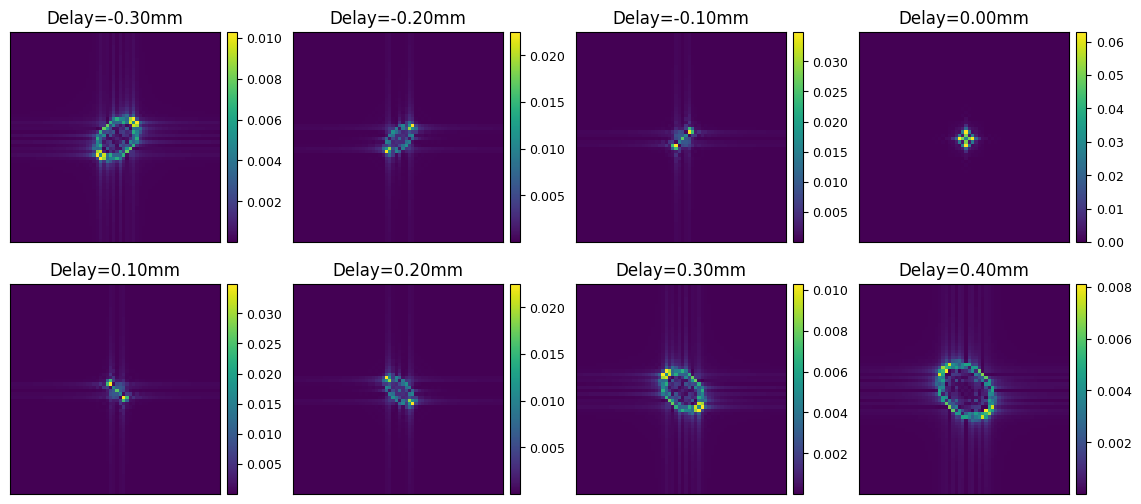

In [157]:
n_delays = 8
delay_step = 1e-4
delays = torch.linspace(-(n_delays/2-1), n_delays/2, n_delays) * delay_step
psfs = []
for delay in delays:
    psfs.append(PSF(theta2D, k2D, w, delay))
    
fig = plt.figure(figsize=(14, 6))
for i in range(8):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(psfs[i])
    plt.title('Delay={:.2f}mm'.format(delays[i]*1e3), fontsize=12)
    plt.xticks([])
    plt.yticks([])
    cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 7.e-3, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize=9)

plt.savefig('../figures/psfs.jpg', bbox_inches='tight')

In [158]:
plt.imsave('../figures/psf.jpg', psfs[-1])